In [1]:
!pip install torchmetrics

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import time

# Load data files
cases_df = pd.read_csv('dataset/scin_cases.csv')
labels_df = pd.read_csv('dataset/scin_labels.csv')

# Merge data frames on case_id
merged_df = pd.merge(cases_df, labels_df, on='case_id')

In [3]:
merged_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [4]:
merged_df['dermatologist_gradable_for_skin_condition_1'].value_counts()

dermatologist_gradable_for_skin_condition_1
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     3049
NO_IMAGE_QUALITY_INSUFFICIENT                            1925
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY      59
Name: count, dtype: int64

In [5]:
merged_df['dermatologist_gradable_for_skin_condition_2'].value_counts()

dermatologist_gradable_for_skin_condition_2
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     464
NO_IMAGE_QUALITY_INSUFFICIENT                            245
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY      7
Name: count, dtype: int64

In [6]:
merged_df['dermatologist_gradable_for_skin_condition_3'].value_counts()

dermatologist_gradable_for_skin_condition_3
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     461
NO_IMAGE_QUALITY_INSUFFICIENT                            243
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY     12
Name: count, dtype: int64

In [7]:
merged_df['dermatologist_skin_condition_confidence'].value_counts()

dermatologist_skin_condition_confidence
[]                          1972
[5]                          312
[4]                          208
[2, 2, 2]                    178
[2, 2]                       176
                            ... 
[3, 3, 2, 4, 1, 1]             1
[1, 1, 2, 2, 5]                1
[1, 4, 1, 4, 2]                1
[4, 4, 3, 1, 1]                1
[4, 1, 1, 1, 1, 5, 4, 2]       1
Name: count, Length: 547, dtype: int64

In [8]:
merged_df['weighted_skin_condition_label'].value_counts()

weighted_skin_condition_label
{}                                                                                                      1972
{'Eczema': 1.0}                                                                                          127
{'Urticaria': 1.0}                                                                                        85
{'Allergic Contact Dermatitis': 1.0}                                                                      42
{'Folliculitis': 1.0}                                                                                     38
                                                                                                        ... 
{'Hidradenitis': 0.8, 'Abscess': 0.2}                                                                      1
{'Drug Rash': 0.5, 'Allergic Contact Dermatitis': 0.5}                                                     1
{'Rosacea': 0.55, 'Allergic Contact Dermatitis': 0.23, 'Cutaneous lupus': 0.23}                   

In [9]:
# # Create Eczema label
# eczema_identifiers = ['Eczema','eczema'] #, 'Dermatitis', 'dermatitis'

# eczema_labels = merged_df['dermatologist_skin_condition_on_label_name'].apply(lambda x: 1 if any(each in x for each in eczema_identifiers) else 0)

# # Add label to merged DataFrame
# merged_df['eczema'] = eczema_labels
# merged_df['eczema'].value_counts()

In [10]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2','dermatologist_gradable_for_skin_condition_3']].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3
0,"[4, 4, 3]","{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN
1,"[4, 3, 4]","{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN
2,"[2, 1, 1]","{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN
3,[],{},NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN
4,"[1, 1, 1]","{'Lichen planus/lichenoid eruption': 0.33, 'Fo...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN


In [11]:
import pandas as pd
import ast

def extract_eczema_value(row):
    # Convert string to list and dictionary
    confidence_list = ast.literal_eval(row['dermatologist_skin_condition_confidence'])
    label_dict = ast.literal_eval(row['weighted_skin_condition_label'])

    # Initialize eczema value to 0
    eczema_value = -1 # not related to eczema or dermatitis

    # Iterate over items in label dictionary
    for i, (key, value) in enumerate(label_dict.items()):
        column_name = f'dermatologist_gradable_for_skin_condition_{i+1}'
        
#         if i < 3: # only column_name_3 exists
#             print(f"column_name={column_name}, value ={row[column_name]} enumerate i ={i}")
        
        # Check if key contains 'Eczema' or 'Dermatitis' and confidence is 4 or 5
        if i< 3 and row[column_name] == 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
            if ('eczema' in key.lower() or 'dermatitis' in key.lower()) and confidence_list[i] in [3, 4, 5]:
                eczema_value = value # eczema or dermatitis ccategory with positive samples
                break
            elif ('eczema' in key.lower() or 'dermatitis' in key.lower()) and confidence_list[i] in [1, 2]:
                eczema_value = 0 # eczema or dermatitis ccategory but negative
                break
            else:
                eczema_value = -1
        else:
            eczema_value = -1
    
    answer = -1
    if eczema_value > 0.5:
        answer = 1
    elif eczema_value >= 0.0:
        answer = 0
    else:
        answer = -1
        
    return answer

# Apply function to dataframe
merged_df['eczema'] = merged_df.apply(extract_eczema_value, axis=1)
merged_df['eczema'].value_counts()

eczema
-1    3896
 0     770
 1     367
Name: count, dtype: int64

In [12]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'eczema']].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,eczema
0,"[4, 4, 3]","{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",-1
1,"[4, 3, 4]","{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",-1
2,"[2, 1, 1]","{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",-1
3,[],{},-1
4,"[1, 1, 1]","{'Lichen planus/lichenoid eruption': 0.33, 'Fo...",-1


In [13]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'eczema']][merged_df['eczema'] ==1].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,eczema
25,[5],{'Eczema': 1.0},1
28,"[3, 1, 1]","{'Infected eczema': 0.55, 'Psoriasis': 0.23, '...",1
35,[5],{'Eczema': 1.0},1
52,[5],{'Eczema': 1.0},1
56,[5],"{'Chronic dermatitis, NOS': 1.0}",1


In [14]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2','dermatologist_gradable_for_skin_condition_3', 'eczema']][merged_df['eczema'] ==0].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,eczema
8,"[1, 3, 3, 2, 4, 3]","{'Eczema': 0.67, 'Psoriasis': 0.11, 'Acute and...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0
10,"[1, 5, 1]","{'Eczema': 0.55, 'Drug Rash': 0.23, 'Allergic ...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,0
17,"[2, 2, 2]","{'Stasis Dermatitis': 0.33, 'Eczema': 0.33, 'A...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,0
18,"[4, 2, 4, 1, 2, 2]","{'Tinea Versicolor': 0.61, 'Seborrheic Dermati...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0
33,"[1, 1, 1, 1, 3, 4]","{'Impetigo': 0.17, 'Allergic Contact Dermatiti...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0


In [15]:
merged_df['eczema'].value_counts()

eczema
-1    3896
 0     770
 1     367
Name: count, dtype: int64

In [16]:
#ignore non eczema dataset
merged_df = merged_df[merged_df['eczema'] != -1] 
merged_df['eczema'].value_counts()

eczema
0    770
1    367
Name: count, dtype: int64

In [17]:
merged_df[['dermatologist_skin_condition_on_label_name', 'eczema']]

,dermatologist_skin_condition_on_label_name,eczema
8,"['Psoriasis', 'Eczema', 'Eczema', 'Acute and c...",0
10,"['Drug Rash', 'Eczema', 'Allergic Contact Derm...",0
17,"['Stasis Dermatitis', 'Eczema', 'Allergic Cont...",0
18,"['Tinea Versicolor', 'Seborrheic Dermatitis', ...",0
25,['Eczema'],1
...,...,...
5014,"['Allergic Contact Dermatitis', 'Irritant Cont...",0
5016,['Stasis Dermatitis'],1
5021,"['Eczema', 'Scabies', 'Hypersensitivity', 'Ecz...",1
5024,"['Pigmented purpuric eruption', 'Stasis Dermat...",0


In [18]:
merged_df['eczema'].value_counts()

eczema
0    770
1    367
Name: count, dtype: int64

In [19]:
merged_df['image_1_shot_type'].value_counts()

image_1_shot_type
CLOSE_UP       628
AT_AN_ANGLE    294
AT_DISTANCE    215
Name: count, dtype: int64

In [20]:
def calculate_image_path(row):
    if row['image_1_shot_type'] == 'CLOSE_UP': #CLOSE_UP, AT_DISTANCE
        return ''+row['image_1_path']
    elif row['image_2_shot_type'] == 'CLOSE_UP':
        return ''+row['image_2_path']
    elif row['image_3_shot_type'] == 'CLOSE_UP':
        return str(row['image_3_path'])
    else:
        return ''  # or any default value if none is found

In [21]:
# Create image path column
merged_df['image_path'] = merged_df.apply(calculate_image_path, axis=1)
len(merged_df)

1137

In [22]:
merged_df = merged_df[merged_df['image_path'].apply(os.path.exists)]
len(merged_df)

1136

In [23]:
merged_df['eczema'].value_counts()

eczema
0    770
1    366
Name: count, dtype: int64

In [24]:
new_df = merged_df[merged_df['eczema'] ==1]['image_path'].reset_index()
new_df.loc[1]['image_path']

'dataset/images/960187272475981264.png'

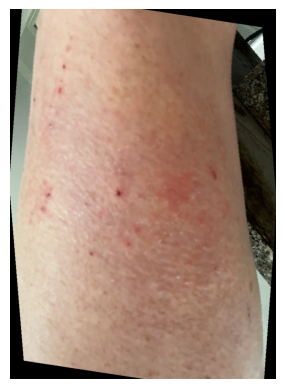

torch.Size([1043, 748, 3])

In [25]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load an image using PIL (you can replace this with your image path)
image_path = new_df.loc[10]['image_path']
image = Image.open(image_path)

transform =  transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ColorJitter(0.5, 0.5, 0.5, 0.1),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  
        transforms.RandomHorizontalFlip(p=0.3),  # Horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.3),   
#         transforms.RandomResizedCrop(192, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, shear=10),
#         transforms.ColorJitter(0.25, 0.25, 0.25, 0.1),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),        
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
image_tensor = transform(image)

# Convert the image tensor from [C, H, W] to [H, W, C] for displaying
image_tensor = image_tensor.permute(1, 2, 0)

# Plot the image using matplotlib
plt.imshow(image_tensor)
plt.axis('off')  # Hide axes for better visual appearance
plt.show()
image_tensor.shape

In [26]:
image_tensor.shape

torch.Size([1043, 748, 3])

In [27]:
# Filter out missing labels and images
filtered_df = merged_df.dropna(subset=['eczema', 'image_path'])

# Split data into training and validation sets
train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)


In [28]:
# Import necessary libraries
from torch.utils.data import Dataset
from PIL import Image
import torch

# Define custom dataset class
class EczemaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        label = self.df.iloc[idx]['eczema']

        image = self.transform(image)
        label = torch.tensor(label,dtype=torch.float)

        return image, label

In [29]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((144, 144)),
#         transforms.ColorJitter(0.5, 0.5, 0.5, 0.1),
#         transforms.RandomHorizontalFlip(),
        
        transforms.RandomRotation(15),  
        transforms.RandomHorizontalFlip(p=0.3),  # Horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.3),   
        transforms.RandomResizedCrop(144, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, shear=10),
        
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),        
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((144, 144)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [30]:
import torch
def spatial_argmax(logit):
    """
    Compute the soft-argmax of a heatmap
    :param logit: A tensor of size BS x H x W
    :return: A tensor of size BS x 2 the soft-argmax in normalized coordinates (-1 .. 1)
    """
    weights = F.softmax(logit.view(logit.size(0), -1), dim=-1).view_as(logit)
    return torch.stack(((weights.sum(1) * torch.linspace(-1, 1, logit.size(2)).to(logit.device)[None]).sum(1),
                        (weights.sum(2) * torch.linspace(-1, 1, logit.size(1)).to(logit.device)[None]).sum(1)), 1)



In [31]:
class Block(torch.nn.Module):
    def __init__(self, n_input, n_output, kernel_size=3, stride=2):
        super().__init__()
        self.c1 = torch.nn.Conv2d(n_input, n_output, kernel_size=kernel_size, padding=kernel_size // 2, stride=stride, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(n_output)
        self.c2 = torch.nn.Conv2d(n_output, n_output, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(n_output)
        self.c3 = torch.nn.Conv2d(n_output, n_output, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(n_output)
        self.skip = torch.nn.Conv2d(n_input, n_output, kernel_size=1, stride=stride)
        self.dropout = torch.nn.Dropout2d(p=0.2)

    def forward(self, x):
        return self.dropout(torch.relu(self.bn3(self.c3(torch.relu(self.bn2(self.c2(torch.relu(self.bn1(self.c1(x)))))))) + self.skip(x)))


class UpBlock(torch.nn.Module):
    def __init__(self, n_input, n_output, kernel_size=3, stride=2):
        super().__init__()
        self.c1 = torch.nn.ConvTranspose2d(n_input, n_output, kernel_size=kernel_size, padding=kernel_size // 2, stride=stride, output_padding=1)

    def forward(self, x):
        return torch.relu(self.c1(x))


In [32]:
class EczemaClassifier(nn.Module):
    def __init__(self, layers=[32, 64, 128, 256, 512], n_output_channels=1, kernel_size=3, use_skip=True):
        super().__init__()
        c = 3  # The number of input channels (RGB images)
        self.use_skip = use_skip
        self.n_conv = len(layers)
        skip_layer_size = [3] + layers[:-1]

        # Convolutional layers (downward)
        for i, l in enumerate(layers):
            self.add_module('conv%d' % i, Block(c, l, kernel_size, 2))
            c = l

        # Transposed convolution layers (upward)
        for i, l in list(enumerate(layers))[::-1]:
            self.add_module('upconv%d' % i, UpBlock(c, l, kernel_size, 2))
            c = l
            if self.use_skip:
                c += skip_layer_size[i]

        # Final classifier layer (output a single value per image)
        self.classifier = torch.nn.Conv2d(c, 1, 1)
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # No normalization here; use the raw input
        z = x  # Input is used as-is, without any pre-processing
        up_activation = []

        # Pass through down-sampling convolutions
        for i in range(self.n_conv):
            up_activation.append(z)
            z = self._modules['conv%d' % i](z)

        # Pass through up-sampling convolutions
        for i in reversed(range(self.n_conv)):
            z = self._modules['upconv%d' % i](z)
            z = z[:, :, :up_activation[i].size(2), :up_activation[i].size(3)]
            if self.use_skip:
                z = torch.cat([z, up_activation[i]], dim=1)

        # Final classification layer
        classifier_output = self.classifier(z)
        classifier_output = self.pool(classifier_output)
        classifier_output = classifier_output.view(-1, 1)  # Reshape to (batch_size, 1) for binary classification
        classifier_output = torch.sigmoid(classifier_output)  # Sigmoid for binary classification

        return classifier_output

    
    
# class EczemaClassifier(nn.Module):
#     def __init__(self, layers=[32, 64, 128,256], n_output_channels=1, kernel_size=3, use_skip=True):
#         super().__init__()
#         self.input_mean = torch.Tensor([0.485, 0.456, 0.406])
#         self.input_std = torch.Tensor([0.229, 0.224, 0.225])
#         c = 3
#         self.use_skip = use_skip
#         self.n_conv = len(layers)
#         skip_layer_size = [3] + layers[:-1]
#         for i, l in enumerate(layers):
#             self.add_module('conv%d' % i, Block(c, l, kernel_size, 2))
#             c = l
#         for i, l in list(enumerate(layers))[::-1]:
#             self.add_module('upconv%d' % i, UpBlock(c, l, kernel_size, 2))
#             c = l
#             if self.use_skip:
#                 c += skip_layer_size[i]
#         # Update the final classifier layer to output 1 channel (single logit per image)
#         self.classifier = torch.nn.Conv2d(c, 1, 1)
#         self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))

#     def forward(self, x):
#         z = (x - self.input_mean[None, :, None, None].to(x.device)) / self.input_std[None, :, None, None].to(x.device)
#         up_activation = []
#         for i in range(self.n_conv):
#             up_activation.append(z)
#             z = self._modules['conv%d'%i](z)

#         for i in reversed(range(self.n_conv)):
#             z = self._modules['upconv%d'%i](z)
#             z = z[:, :, :up_activation[i].size(2), :up_activation[i].size(3)]
#             if self.use_skip:
#                 z = torch.cat([z, up_activation[i]], dim=1)
#         classifier_output = self.classifier(z)
#         classifier_output = self.pool(classifier_output)
#         classifier_output = classifier_output.view(-1, 1)  # Reshape to (batch_size, 1) for binary classification
#         classifier_output = torch.sigmoid(classifier_output) 
#         return classifier_output


In [33]:
len(train_df), len(val_df)

(908, 228)

In [34]:
train_df['eczema'].value_counts()

eczema
0    619
1    289
Name: count, dtype: int64

In [35]:
val_df['eczema'].value_counts()

eczema
0    151
1     77
Name: count, dtype: int64

In [36]:
def save_model(model, epoch, val_acc):
    scripted_model = torch.jit.script(model)
    torch.jit.save(scripted_model, f'resnet18-model-eczema-{epoch}-{val_acc:.4f}.pth')

In [37]:
import torch
from collections import Counter

# Step 1: Load and prepare your dataset (assuming your dataset is loaded into `train_df`)
# Assuming labels are stored in a column named 'label'

# Check the distribution of the classes in your dataset
class_counts = Counter(train_df['eczema'])
print(f"Class distribution: {class_counts}")

# Step 2: Calculate the number of samples for each class
num_positive = class_counts[1]
num_negative = class_counts[0]

print(f"Number of positive samples: {num_positive}")
print(f"Number of negative samples: {num_negative}")

# Step 3: Compute the pos_weight
# pos_weight is typically set to the ratio of negative to positive examples
pos_weight = num_negative / num_positive
print(f"Pos weight calculated: {pos_weight}")

Class distribution: Counter({0: 619, 1: 289})
Number of positive samples: 289
Number of negative samples: 619
Pos weight calculated: 2.141868512110727


In [38]:
# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

model = EczemaClassifier().to(device)
print(model)

device=cuda
EczemaClassifier(
  (conv0): Block(
    (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
    (dropout): Dropout2d(p=0.2, inplace=False)
  )
  (conv1): Block(
    (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNor

In [39]:
from torchmetrics.classification import ConfusionMatrix, Accuracy
conf_mat = ConfusionMatrix(num_classes=2, task="BINARY").to(device)
accuracy_mat = Accuracy(num_classes=2, task="BINARY").to(device)


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

global_step = 0
global_epochs = 0

In [40]:
# Create data loaders
train_dataset = EczemaDataset(train_df, data_transforms['train'])
val_dataset = EczemaDataset(val_df, data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True) # 2500
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Step 4: Create class weights tensor and move it to the correct device (GPU or CPU)
pos_weight_tensor = torch.tensor([pos_weight]).to(device)
print(f"pos_weight_tensor={pos_weight_tensor}")
# Step 5: Use the pos_weight in BCEWithLogitsLoss
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

pos_weight_tensor=tensor([2.1419], device='cuda:0')


In [42]:
import torch.nn.functional as F
for epoch in range(40):
    start_time = time.time()  # Start timer

    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        global_epochs +=1
        writer.add_scalar('Loss/train', loss.item(), global_epochs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #scheduler step()
    scheduler.step()
        
    end_time = time.time()  # End timer
    epoch_time = end_time - start_time
    global_step += 1
    
    if global_step % 5 !=0:
        print(f'Epoch: {global_step}, Training Loss: {running_loss / len(train_loader)}, Time: {epoch_time:.2f} seconds ')
    else:
        conf_mat.reset()
        accuracy_mat.reset()
        model.eval()
        with torch.no_grad():
            for images, target in val_loader:
                images, target = images.to(device), target.to(device)
                target = target.unsqueeze(1)
                
                outputs = model(images)
                predicted = (outputs > 0.5).float()
    
                conf_mat.update(predicted, target)
                accuracy_mat.update(predicted, target)
            val_acc = accuracy_mat.compute()
            print(f'Epoch: {global_step}, Training Loss: {running_loss / len(train_loader)}, Time: {epoch_time:.2f} seconds ,Val Accuracy: {val_acc:.4f}')
            if global_step % 10 ==0:
                print('Confusion Matrix:')
                print(conf_mat.compute())
                print(f'TP: {conf_mat.compute()[1,1]}, TN: {conf_mat.compute()[0,0]}, FP: {conf_mat.compute()[0,1]}, FN: {conf_mat.compute()[1,0]}')

#             save_model(model,global_step,val_acc)

Epoch: 1, Training Loss: 0.989484041929245, Time: 40.85 seconds 
Epoch: 2, Training Loss: 0.9882367998361588, Time: 29.13 seconds 
Epoch: 3, Training Loss: 0.9855912029743195, Time: 26.35 seconds 
Epoch: 4, Training Loss: 0.9827002733945847, Time: 26.39 seconds 
Epoch: 5, Training Loss: 0.9765456318855286, Time: 25.85 seconds ,Val Accuracy: 0.6623
Epoch: 6, Training Loss: 0.9682481735944748, Time: 35.40 seconds 
Epoch: 7, Training Loss: 0.9663511663675308, Time: 49.70 seconds 
Epoch: 8, Training Loss: 0.9655702114105225, Time: 50.61 seconds 
Epoch: 9, Training Loss: 0.9632617831230164, Time: 43.59 seconds 
Epoch: 10, Training Loss: 0.9580353051424026, Time: 37.32 seconds ,Val Accuracy: 0.6623
Confusion Matrix:
tensor([[151,   0],
        [ 77,   0]], device='cuda:0')
TP: 0, TN: 151, FP: 0, FN: 77


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score


model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        
        # Convert logits to predicted class (0 or 1) using a threshold of 0.5
        preds = (outputs > 0.5).float()  # 0.5 threshold for binary classification

        # Append predictions and labels to lists
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)

all_labels = np.concatenate(all_labels, axis=0)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# ROC-AUC for binary classification
auc = roc_auc_score(all_labels, all_preds)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print out the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"Confusion Matrix:\n{cm}")

In [ ]:
# model.eval()
# with torch.no_grad():
#     correct = 0
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#     val_accuracy = correct / len(val_df)
#     print(f'Val Accuracy: {val_accuracy:.4f}')

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.classification import ConfusionMatrix, Accuracy

conf_mat = ConfusionMatrix(num_classes=2, task="BINARY").to(device)
accuracy = Accuracy(num_classes=2, task="BINARY").to(device)

conf_mat.reset()
accuracy_mat.reset()
model.eval()
with torch.no_grad():
    for images, target in val_loader:
        images, target = images.to(device), target.to(device)
        target = target.unsqueeze(1)

        outputs = model(images)
        predicted = (outputs > 0.5).float()

        conf_mat.update(predicted, target)
        accuracy_mat.update(predicted, target)
    val_acc = accuracy_mat.compute()
    print(f'Epoch {global_step}, Val Accuracy: {val_acc:.4f}')
    print('Confusion Matrix:')
    print(conf_mat.compute())
    print(f'TP: {conf_mat.compute()[1,1]}, TN: {conf_mat.compute()[0,0]}, FP: {conf_mat.compute()[0,1]}, FN: {conf_mat.compute()[1,0]}')


In [ ]:
# scripted_model = torch.jit.script(model)
# torch.jit.save(scripted_model, 'resnet18-model-eczema-0.7815.pth')

In [ ]:
# loaded_model = loaded_model = torch.jit.load('resnet18-model-eczema-0.7815.pth')